In [3]:
import numpy as np
import xarray as xr

import rasterio.features
import stackstac
import pystac_client
import planetary_computer

import xrspatial.multispectral as ms

import pandas as pd
import geopandas as gpd
from datetime import datetime
from shapely.geometry import shape
import shapely
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Step 1

Extract SandSnap data to a pandas dataframe. Clean the dataframe, rename columns and drop unused columns

Clean the date format

In [24]:
marchetti_df = pd.read_csv('../../data/marchetti-sample28.csv')
marchetti_df['date'] =  pd.to_datetime(marchetti_df['date'], infer_datetime_format=True).dt.date
marchetti_df

,objectid,D50,lon,lat,date,category
0,29355,0.016398,9.528244,45.082526,2018-09-22,mud
1,33756,0.026002,9.878213,45.120831,2018-09-22,mud
2,39501,0.003804,10.284645,45.003129,2018-09-22,mud
3,34438,0.061421,9.882791,45.117144,2018-09-22,mud
4,39470,0.115909,10.287061,45.003219,2018-09-22,VFS
5,34327,0.093158,9.882664,45.117863,2018-09-22,VFS
6,31679,0.074936,9.888260,45.134678,2018-09-22,VFS
7,29170,0.123040,9.523793,45.086842,2018-09-22,VFS
8,30104,0.172264,9.644477,45.110400,2018-09-22,FS
9,40317,0.193146,10.331952,44.980200,2018-09-22,FS


### Summary stats for grain size params

In [7]:
marchetti_df[['D50']].describe()


,D50
count,28.000000
mean,3.161823
std,6.804670
min,0.003804
25%,0.121258
50%,0.314833
75%,1.019499
max,21.800375


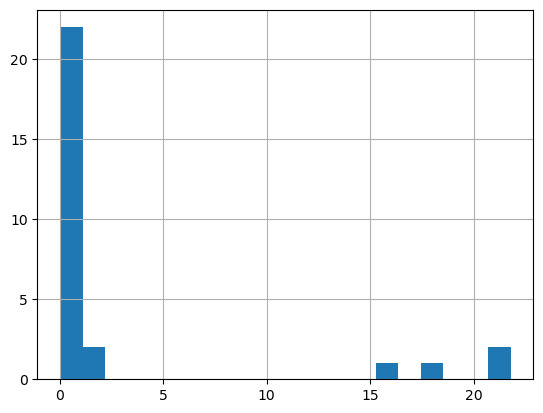

In [8]:
marchetti_df['D50'].hist(bins=20)
plt.show()

In [9]:
marchetti_df.dtypes

Unnamed: 0      int64
D50           float64
lon           float64
lat           float64
date           object
category       object
dtype: object

## Iterate over each entry and analyze

We will use a naive extraction method, which will be wasteful because these coordinates are likely to be covered by one or few NAIP tiles. But for the sake of simplicity, we will extract the NAIP tile that overlaps with each coordinate, and construct the texture features


In [10]:
side_len_deg = 0.0001 #~11.1m

In [11]:
def bbox(lon, lat, side_len_deg = 0.0001):
    point_geom  = shapely.geometry.mapping(shapely.geometry.Point(lon, lat))
    point_shape = shapely.geometry.shape(point_geom)
    #Create a square out of it with side_length = buffer*2
    mask_shape  = point_shape.buffer(side_len_deg/2.).envelope
    aoi   = shapely.geometry.mapping(mask_shape)
    return aoi
    # return rasterio.features.bounds(aoi)

Using pystac_client we can search the Planetary Computer's STAC endpoint for items matching our query parameters.

In [12]:
collection = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [13]:
#returns the closest date 
def nearest_date(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

To select the nearest time to a desired time value, we set it to use a nearest neighbour method, 'nearest'. We have to specify the time using a datetime object. [ref](https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Frequently_used_code/Working_with_time.html)

TODO:
1. Select closest date
2. Check for rainfall near that date - some temporal buffer


In [14]:
import operator

def cropCenter(img, bounding):
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))
    end = tuple(map(operator.add, start, bounding))
    slices = tuple(map(slice, start, end))
    return img[slices]

In [15]:
BANDS = ["B04","B03","B02", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]

In [16]:
import pyproj

GSD = 10.0 #m/px

def area_of_overlap(item, aoi):
    area_shape = shape(aoi)
    aoi_area = area_shape.area
    
    
    aoi_area = shape(aoi).area
    
    overlap_area = shape(item.geometry).intersection(shape(aoi)).area
    # print(aoi_area, overlap_area)
    return overlap_area / aoi_area


def S2_data(date, lon, lat, bands = BANDS,\
            limit_months=5, window_size_px=10, add_to_map=None):
    """
    parameters:
    date: datetime object of the time of observation capture
    lon, lat : coordinates of observation
    bands : list of Sentinel 2 band names
    limit_months : maximum duration before and after date to search for
    buffer : area to crop around (lon,lat) in meters, i.e. a square with side buffer
    
    return type:
    window_size_px : if > 1, will return a numpy array DN values at all pixels within window
            if 1, will return a list of DN values per band at that pixel
    """
    
    #Create a window of limit_months around the acquisition date to search for NAIP data
    start_date, end_date = date - relativedelta(months=int(limit_months/2)), \
                            date + relativedelta(months=int(limit_months/2))


    date_range = start_date.strftime('%Y-%m-%d') + "/" + end_date.strftime('%Y-%m-%d')
    
    aoi = bbox(lon, lat)

    search = collection.search(
        # bbox=aoi, 
        intersects=aoi,
        datetime=date_range,
        collections=["sentinel-2-l2a"],
        query={"eo:cloud_cover": {"lt": 10}},
        limit=20,
    )
    
    items = search.item_collection()
    
    if len(items) == 0:
        print ("No tiles found in ", date_range)
        return None
    
    if len(items) > 0:
        tile = items[0]
    else:
        tile = items
    
        
    delta_days = abs((tile.datetime.date() - date).days)
    
    if len(items) > 0:
        delta_min = 1e9
        
        #Choose the item that's closest in time to the sandsnap item's
        for i, item in enumerate(items):
            delta_days = abs((item.datetime.date() - date).days)
            # print(delta_days)
            if delta_days < delta_min:
                delta_min = delta_days
                tile = item
                
    #Make sure area of overlap is 100%
    if area_of_overlap(tile,aoi) != 1:
        return None
    
    # print("{:} overlapping tile(s) for: {:} | Delta:{:} days"\
    #   .format(len(items),date_range,delta_days))
    
    chosen = stackstac.stack(
        tile,
        assets=bands, 
        # epsg = crs,
        # epsg=3857,
        # chunksize=4096,
        # resolution=100,
    ).where(lambda x: x > 0, other=np.nan).assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names \  # sentinel-2 uses 0 as nodata
    tile = chosen[0] #still has time dimension - removing with this step

    #This is done because the different S2 tiles can have different UTM zones and CRS's
    #that trips up Stackstac -> so choose the epsg as one of them and force them all to be the same
    #OR bypass this process all together and use simple logic to choose the closest date
#     crs = items[0].properties['proj:epsg']
    
#     #convert to xarray with stacstac
#     all_bands = stackstac.stack(
#         items,
#         assets=bands, 
#         epsg = crs,
#         # epsg=3857,
#         # chunksize=4096,
#         # resolution=100,
#     ).where(lambda x: x > 0, other=np.nan).assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names \  # sentinel-2 uses 0 as nodata
    
#     # display(all_bands)
    
#     #Find the one with the closest to date of observation
#     #Doesnt work
#     # return data.sel(time=target_time, method='nearest')
    
#     if all_bands.sizes['time'] > 1: #when the collection (i.e. time dimension) has more than one entry
#         tile = all_bands.sortby(all_bands['eo:cloud_cover'])[0]
#     else:
#         tile = all_bands
    
    # return data
    #Now crop out the AOI:
    x_utm, y_utm = pyproj.Proj(tile.crs)(lon, lat)
    
    #define buffer size in meter to be about 20% larger than required window size
    buffer_m = 100
    window_size_m = window_size_px*GSD
    
    #Make sure buffer isnt too small to correct for skewing of crop box
    buffer_m = window_size_m if window_size_m > buffer_m else buffer_m
    
    aoi = tile.loc[..., y_utm+(buffer_m/2.):y_utm-(buffer_m/2.), x_utm-(buffer_m/2.):x_utm+(buffer_m/2.)]
    # rgb = aoi.sel(band=["red", "green", "blue"])
    aoi = aoi.compute()
    
    # display(aoi)
    aoi_np = aoi.to_numpy()
    
    #Now crop to window size:
    img_patch = cropCenter(aoi_np, (aoi_np.shape[0],window_size_px,window_size_px)) #4 for 4 channels
    
    if add_to_map:
        
        stackstac.add_to_map(aoi[0:3], add_to_map, "", range=[0, 3000])
        marker = ipyleaflet.Marker(location=(lat,lon), draggable=False)
        add_to_map.add_layer(marker);
    
    if img_patch.shape[1] == 1 and img_patch.shape[2] == 1: #i.e. the number of pixels is one
        return img_patch.reshape(len(img_patch)).tolist()
    return img_patch
    

## Update DF with band values

In [25]:
#drop the first entry, aka outlier with D50 = 3.5mm
# world = world.drop(world.index[0]).reset_index(drop=True)

for band in BANDS:
    marchetti_df[band] = np.NaN
    
marchetti_df

,objectid,D50,lon,lat,date,category,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12
0,29355,0.016398,9.528244,45.082526,2018-09-22,mud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,33756,0.026002,9.878213,45.120831,2018-09-22,mud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,39501,0.003804,10.284645,45.003129,2018-09-22,mud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,34438,0.061421,9.882791,45.117144,2018-09-22,mud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,39470,0.115909,10.287061,45.003219,2018-09-22,VFS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,34327,0.093158,9.882664,45.117863,2018-09-22,VFS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,31679,0.074936,9.888260,45.134678,2018-09-22,VFS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,29170,0.123040,9.523793,45.086842,2018-09-22,VFS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,30104,0.172264,9.644477,45.110400,2018-09-22,FS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,40317,0.193146,10.331952,44.980200,2018-09-22,FS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
import warnings
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm
import time
from IPython.display import clear_output

def get_values(df, m):
    """
    """
    
    keep = False
    for index, sample in tqdm(df.iterrows(), total=df.shape[0]): #shape is required to tell tqdm the total elements
        m.center = sample['lat'],sample['lon']
        DNs_point = S2_data(sample['date'], sample['lon'], sample['lat'], window_size_px=200, add_to_map=m)
        # time.sleep(10)
        if DNs_point is None:
            print("No tiles for ", sample['objectid'])
            continue
        
        display(sample)
        inp = input("[{:} {:} {:}] Enter y to keep / anything else to discard: ".format(sample['objectid'],  sample['lat'], sample['lon']))
        keep = inp == 'y'  
        # time.sleep(5)
        clear_output()
        
        
        if (keep):
            DNs_point = S2_data(sample['date'], sample['lon'], sample['lat'], window_size_px=1)
            print("Kept Observation")
            for b, band in enumerate(BANDS):
                # print(b, band)
                df[band].iloc[index] = DNs_point[b]

        

In [19]:
from dask_gateway import GatewayCluster
cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.

client = cluster.get_client()

cluster.adapt(minimum=8, maximum=24)
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.7522494fd35f4fd1b5c85b9246eac2f5/status


In [20]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.7522494fd35f4fd1b5c85b9246eac2f5/status,


In [26]:
import ipyleaflet
m = ipyleaflet.Map()
m.center = center = marchetti_df['lat'][0],marchetti_df['lon'][0]
m.zoom = 16
m.layout.height = "700px"
#stackstac.add_to_map(tile1[4:7], m, "s2", range=[0, 3000])
display(m)

Map(center=[45.0825259156, 9.528244201], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_t…

In [27]:

# %%time
client.wait_for_workers(2, timeout=10)
get_values(marchetti_df, m)


NameError: name 'world' is not defined

In [28]:
marchetti_df

,objectid,D50,lon,lat,date,category,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12
0,29355,0.016398,9.528244,45.082526,2018-09-22,mud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,33756,0.026002,9.878213,45.120831,2018-09-22,mud,2286.0,2100.0,1788.0,2539.0,2543.0,2573.0,2448.0,2535.0,3296.0,3183.0
2,39501,0.003804,10.284645,45.003129,2018-09-22,mud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,34438,0.061421,9.882791,45.117144,2018-09-22,mud,2258.0,2138.0,1832.0,2583.0,2637.0,2720.0,2658.0,2696.0,3511.0,3418.0
4,39470,0.115909,10.287061,45.003219,2018-09-22,VFS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,34327,0.093158,9.882664,45.117863,2018-09-22,VFS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,31679,0.074936,9.888260,45.134678,2018-09-22,VFS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,29170,0.123040,9.523793,45.086842,2018-09-22,VFS,2442.0,2164.0,1746.0,2566.0,2659.0,2713.0,2784.0,2754.0,3533.0,3412.0
8,30104,0.172264,9.644477,45.110400,2018-09-22,FS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,40317,0.193146,10.331952,44.980200,2018-09-22,FS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Wait for 4 workers for upto 10 seconds

array([[<AxesSubplot:title={'center':'D50'}>]], dtype=object)

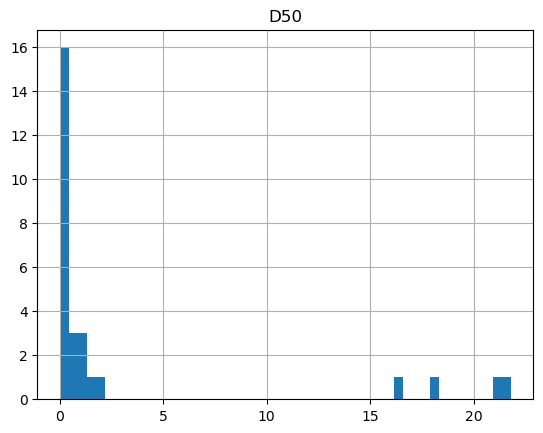

In [31]:
marchetti_df[['D50']].hist(bins=50)

## Multiple regression

### Remove all NaNs

In [44]:
df = marchetti_df[marchetti_df['B02'].notna()].reset_index(drop=True).copy()
df

,objectid,D50,lon,lat,date,category,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12
0,33756,0.026002,9.878213,45.120831,2018-09-22,mud,2286.0,2100.0,1788.0,2539.0,2543.0,2573.0,2448.0,2535.0,3296.0,3183.0
1,34438,0.061421,9.882791,45.117144,2018-09-22,mud,2258.0,2138.0,1832.0,2583.0,2637.0,2720.0,2658.0,2696.0,3511.0,3418.0
2,29170,0.123040,9.523793,45.086842,2018-09-22,VFS,2442.0,2164.0,1746.0,2566.0,2659.0,2713.0,2784.0,2754.0,3533.0,3412.0
3,32879,0.279931,9.880502,45.125147,2018-09-22,MS,2388.0,2222.0,1906.0,2664.0,2664.0,2763.0,2678.0,2775.0,3641.0,3538.0
4,32877,0.288299,9.879231,45.125147,2018-09-22,MS,2186.0,2072.0,1762.0,2192.0,2446.0,2569.0,2664.0,2684.0,3365.0,3008.0
5,34998,0.746540,10.027255,45.098801,2018-09-22,CS,2018.0,1848.0,1584.0,2346.0,2378.0,2498.0,2310.0,2497.0,3098.0,2918.0
6,33637,0.756305,9.958075,45.121280,2018-09-22,CS,2454.0,2304.0,2020.0,2695.0,2655.0,2763.0,2654.0,2731.0,3691.0,3682.0
7,37720,0.544344,10.138782,45.031453,2018-09-22,CS,2422.0,2194.0,1882.0,2737.0,2782.0,2925.0,2774.0,2898.0,3804.0,3798.0
8,37193,0.925641,10.158748,45.035859,2018-09-22,CS,1992.0,1876.0,1608.0,2342.0,2456.0,2603.0,2568.0,2585.0,3273.0,3249.0
9,40066,1.077730,10.328264,44.981279,2018-09-22,VCS,2208.0,1980.0,1688.0,2428.0,2475.0,2558.0,2470.0,2535.0,3356.0,3301.0


In [33]:
df.isna().sum()

objectid    0
D50         0
lon         0
lat         0
date        0
category    0
B04         0
B03         0
B02         0
B05         0
B06         0
B07         0
B08         0
B8A         0
B11         0
B12         0
dtype: int64

## Convert Band values to absolute reflectance

For Sentinel-2 optical data (L2A), the relation between DN and REFLECTANCE (default unit) is: DN = 10000 * REFLECTANCE [Source](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/)

Therefore divide by 10000. to get the reflectance value

In [34]:
df[BANDS] = df[BANDS]/(10000.)
df

,objectid,D50,lon,lat,date,category,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12
0,33756,0.026002,9.878213,45.120831,2018-09-22,mud,0.2286,0.2100,0.1788,0.2539,0.2543,0.2573,0.2448,0.2535,0.3296,0.3183
1,34438,0.061421,9.882791,45.117144,2018-09-22,mud,0.2258,0.2138,0.1832,0.2583,0.2637,0.2720,0.2658,0.2696,0.3511,0.3418
2,29170,0.123040,9.523793,45.086842,2018-09-22,VFS,0.2442,0.2164,0.1746,0.2566,0.2659,0.2713,0.2784,0.2754,0.3533,0.3412
3,32879,0.279931,9.880502,45.125147,2018-09-22,MS,0.2388,0.2222,0.1906,0.2664,0.2664,0.2763,0.2678,0.2775,0.3641,0.3538
4,32877,0.288299,9.879231,45.125147,2018-09-22,MS,0.2186,0.2072,0.1762,0.2192,0.2446,0.2569,0.2664,0.2684,0.3365,0.3008
5,34998,0.746540,10.027255,45.098801,2018-09-22,CS,0.2018,0.1848,0.1584,0.2346,0.2378,0.2498,0.2310,0.2497,0.3098,0.2918
6,33637,0.756305,9.958075,45.121280,2018-09-22,CS,0.2454,0.2304,0.2020,0.2695,0.2655,0.2763,0.2654,0.2731,0.3691,0.3682
7,37720,0.544344,10.138782,45.031453,2018-09-22,CS,0.2422,0.2194,0.1882,0.2737,0.2782,0.2925,0.2774,0.2898,0.3804,0.3798
8,37193,0.925641,10.158748,45.035859,2018-09-22,CS,0.1992,0.1876,0.1608,0.2342,0.2456,0.2603,0.2568,0.2585,0.3273,0.3249
9,40066,1.077730,10.328264,44.981279,2018-09-22,VCS,0.2208,0.1980,0.1688,0.2428,0.2475,0.2558,0.2470,0.2535,0.3356,0.3301


## Find outliers


<AxesSubplot:xlabel='objectid', ylabel='D50'>

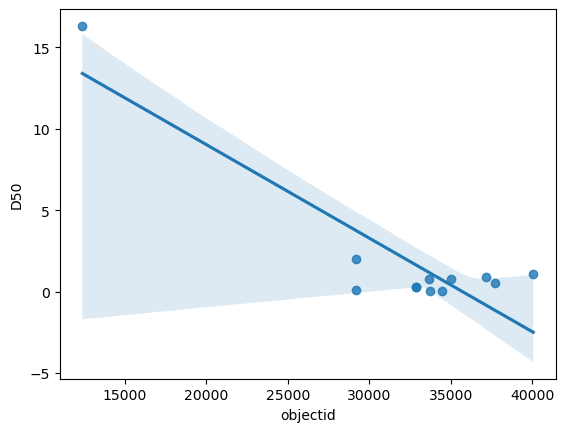

In [35]:
sns.regplot(x='objectid', y='D50', data=df)

In [40]:
df[df.D50 > 5]

,objectid,D50,lon,lat,date,category,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12
11,12374,16.315145,8.627506,45.069038,2018-09-22,gravel,0.2636,0.2476,0.208,0.2901,0.2885,0.286,0.3008,0.2895,0.3258,0.2895


We know from a qualitative inspection of this observation that it had a bunch of shells in it, in an otherwise relatively homogenous grain distribution. 
Also there were many data points nearby which all had much lower D50. Hence, remove

In [41]:
df = df[df.D50 < 5].reset_index(drop=True)
df

,objectid,D50,lon,lat,date,category,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12
0,33756,0.026002,9.878213,45.120831,2018-09-22,mud,0.2286,0.2100,0.1788,0.2539,0.2543,0.2573,0.2448,0.2535,0.3296,0.3183
1,34438,0.061421,9.882791,45.117144,2018-09-22,mud,0.2258,0.2138,0.1832,0.2583,0.2637,0.2720,0.2658,0.2696,0.3511,0.3418
2,29170,0.123040,9.523793,45.086842,2018-09-22,VFS,0.2442,0.2164,0.1746,0.2566,0.2659,0.2713,0.2784,0.2754,0.3533,0.3412
3,32879,0.279931,9.880502,45.125147,2018-09-22,MS,0.2388,0.2222,0.1906,0.2664,0.2664,0.2763,0.2678,0.2775,0.3641,0.3538
4,32877,0.288299,9.879231,45.125147,2018-09-22,MS,0.2186,0.2072,0.1762,0.2192,0.2446,0.2569,0.2664,0.2684,0.3365,0.3008
5,34998,0.746540,10.027255,45.098801,2018-09-22,CS,0.2018,0.1848,0.1584,0.2346,0.2378,0.2498,0.2310,0.2497,0.3098,0.2918
6,33637,0.756305,9.958075,45.121280,2018-09-22,CS,0.2454,0.2304,0.2020,0.2695,0.2655,0.2763,0.2654,0.2731,0.3691,0.3682
7,37720,0.544344,10.138782,45.031453,2018-09-22,CS,0.2422,0.2194,0.1882,0.2737,0.2782,0.2925,0.2774,0.2898,0.3804,0.3798
8,37193,0.925641,10.158748,45.035859,2018-09-22,CS,0.1992,0.1876,0.1608,0.2342,0.2456,0.2603,0.2568,0.2585,0.3273,0.3249
9,40066,1.077730,10.328264,44.981279,2018-09-22,VCS,0.2208,0.1980,0.1688,0.2428,0.2475,0.2558,0.2470,0.2535,0.3356,0.3301


## Save file to disk

In [64]:
df.to_csv('../data/norcal-berm-reflectance.csv')



## Regress D50/D90/D10

In [45]:
import statsmodels.formula.api as smf 
#["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
# formula: response ~ predictor + predictor 
model = smf.ols(formula='D50 ~ B02 + B03 + B04 + B05 + B06 + B07 + B08 + B8A + B11 + B12', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     21.41
Date:                Sat, 18 Mar 2023   Prob (F-statistic):              0.167
Time:                        01:58:18   Log-Likelihood:                -2.4967
No. Observations:                  12   AIC:                             26.99
Df Residuals:                       1   BIC:                             32.33
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -15.2060     10.039     -1.515      0.371    -142.770     112.358
B02            0.0381      0.015      2.468      0.245      -0.158       0.234
B03           -0.0780      0.034     -2.295      0.262      -0.510       0.354
B04            0.0399      0.014      2.796      0.219      -0.141       0.221
B05            0.0358      0.022      1.619      0.352      -0.245       0.317
B06           -0.0976      0.040     -2.470      0.245      -0.600       0.405
B07            0.1357      0.048      2.828      0.216      -0.474       0.746
B08            0.0573      0.022      2.616      0.232      -0.221       0.336
B8A           -0.1192      0.053     -2.243      0.267      -0.794       0.556
B11            0.0460      0.040      1.161      0.453      -0.457       0.549
B12           -0.0510      0.027     -1.915      0.306      -0.389       0.287
==============================================================================
Omnibus:                        0.013   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.994   Jarque-Bera (JB):                0.225
Skew:                           0.037   Prob(JB):                        0.893
Kurtosis:                       2.333   Cond. No.                     2.83e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.83e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
import statsmodels.formula.api as smf 
#["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]
# formula: response ~ predictor + predictor 
model = smf.ols(formula='D50 ~ B04 + B07 + B11 + B12', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                 -0.353
Method:                 Least Squares   F-statistic:                    0.3476
Date:                Sat, 18 Mar 2023   Prob (F-statistic):              0.837
Time:                        01:57:54   Log-Likelihood:                -7.9092
No. Observations:                  11   AIC:                             25.82
Df Residuals:                       6   BIC:                             27.81
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0385      6.666      0.756      0.478     -11.271      21.348
B04           10.2280     24.411      0.419      0.690     -49.504      69.960
B07           -8.5701     65.591     -0.131      0.900    -169.067     151.926
B11          -37.4918     48.127     -0.779      0.466    -155.254      80.270
B12           25.3441     25.659      0.988      0.361     -37.442      88.130
==============================================================================
Omnibus:                        3.617   Durbin-Watson:                   0.532
Prob(Omnibus):                  0.164   Jarque-Bera (JB):                0.969
Skew:                           0.601   Prob(JB):                        0.616
Kurtosis:                       3.818   Cond. No.                         436.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     4.145
Date:                Sat, 18 Mar 2023   Prob (F-statistic):             0.0691
Time:                        02:04:35   Log-Likelihood:                -32.644
No. Observations:                  12   AIC:                             69.29
Df Residuals:                      10   BIC:                             70.26
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -27.2511     14.379     -1.895      0.087     -59.289       4.786
B02            0.0162      0.008      2.036      0.069      -0.002       0.034
==============================================================================
Omnibus:                        9.755   Durbin-Watson:                   1.061
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                4.969
Skew:                           1.340   Prob(JB):                       0.0834
Kurtosis:                       4.661   Cond. No.                     2.23e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.23e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     5.868
Date:                Sat, 18 Mar 2023   Prob (F-statistic):             0.0359
Time:                        02:04:35   Log-Likelihood:                -31.954
No. Observations:                  12   AIC:                             67.91
Df Residuals:                      10   BIC:                             68.88
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -31.9136     14.013     -2.277      0.046     -63.136      -0.692
B03            0.0159      0.007      2.422      0.036       0.001       0.031
==============================================================================
Omnibus:                        7.110   Durbin-Watson:                   1.351
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                3.402
Skew:                           1.230   Prob(JB):                        0.182
Kurtosis:                       3.866   Cond. No.                     2.72e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.72e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     4.204
Date:                Sat, 18 Mar 2023   Prob (F-statistic):             0.0675
Time:                        02:04:35   Log-Likelihood:                -32.619
No. Observations:                  12   AIC:                             69.24
Df Residuals:                      10   BIC:                             70.21
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -28.7401     15.002     -1.916      0.084     -62.167       4.686
B04            0.0133      0.006      2.050      0.067      -0.001       0.028
==============================================================================
Omnibus:                       11.792   Durbin-Watson:                   1.371
Prob(Omnibus):                  0.003   Jarque-Bera (JB):                6.573
Skew:                           1.554   Prob(JB):                       0.0374
Kurtosis:                       4.866   Cond. No.                     2.99e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     4.569
Date:                Sat, 18 Mar 2023   Prob (F-statistic):             0.0583
Time:                        02:04:35   Log-Likelihood:                -32.467
No. Observations:                  12   AIC:                             68.93
Df Residuals:                      10   BIC:                             69.90
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -31.2972     15.585     -2.008      0.072     -66.023       3.429
B05            0.0131      0.006      2.138      0.058      -0.001       0.027
==============================================================================
Omnibus:                       10.132   Durbin-Watson:                   1.186
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                5.271
Skew:                           1.406   Prob(JB):                       0.0717
Kurtosis:                       4.623   Cond. No.                     3.47e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.47e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     5.382
Date:                Sat, 18 Mar 2023   Prob (F-statistic):             0.0428
Time:                        02:04:35   Log-Likelihood:                -32.141
No. Observations:                  12   AIC:                             68.28
Df Residuals:                      10   BIC:                             69.25
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -45.6733     20.548     -2.223      0.050     -91.457       0.111
B06            0.0183      0.008      2.320      0.043       0.001       0.036
==============================================================================
Omnibus:                        7.426   Durbin-Watson:                   1.198
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                3.404
Skew:                           1.161   Prob(JB):                        0.182
Kurtosis:                       4.191   Cond. No.                     4.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     1.975
Date:                Sat, 18 Mar 2023   Prob (F-statistic):              0.190
Time:                        02:04:35   Log-Likelihood:                -33.643
No. Observations:                  12   AIC:                             71.29
Df Residuals:                      10   BIC:                             72.26
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -36.1555     27.131     -1.333      0.212     -96.606      24.295
B07            0.0142      0.010      1.405      0.190      -0.008       0.037
==============================================================================
Omnibus:                       19.181   Durbin-Watson:                   0.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.740
Skew:                           1.971   Prob(JB):                     0.000630
Kurtosis:                       6.735   Cond. No.                     5.77e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.77e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     6.485
Date:                Sat, 18 Mar 2023   Prob (F-statistic):             0.0290
Time:                        02:04:35   Log-Likelihood:                -31.726
No. Observations:                  12   AIC:                             67.45
Df Residuals:                      10   BIC:                             68.42
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -40.0296     16.512     -2.424      0.036     -76.820      -3.239
B08            0.0159      0.006      2.546      0.029       0.002       0.030
==============================================================================
Omnibus:                        6.329   Durbin-Watson:                   1.320
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                2.930
Skew:                           1.150   Prob(JB):                        0.231
Kurtosis:                       3.757   Cond. No.                     4.06e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     2.697
Date:                Sat, 18 Mar 2023   Prob (F-statistic):              0.132
Time:                        02:04:35   Log-Likelihood:                -33.292
No. Observations:                  12   AIC:                             70.58
Df Residuals:                      10   BIC:                             71.55
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -40.0515     25.589     -1.565      0.149     -97.068      16.965
B8A            0.0156      0.010      1.642      0.132      -0.006       0.037
==============================================================================
Omnibus:                       15.136   Durbin-Watson:                   0.950
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                9.795
Skew:                           1.703   Prob(JB):                      0.00746
Kurtosis:                       5.825   Cond. No.                     5.61e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.9354
Date:                Sat, 18 Mar 2023   Prob (F-statistic):              0.356
Time:                        02:04:35   Log-Likelihood:                -34.188
No. Observations:                  12   AIC:                             72.38
Df Residuals:                      10   BIC:                             73.35
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     24.3002     23.170      1.049      0.319     -27.325      75.925
B11           -0.0065      0.007     -0.967      0.356      -0.022       0.008
==============================================================================
Omnibus:                       27.127   Durbin-Watson:                   1.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.788
Skew:                           2.549   Prob(JB):                     9.24e-07
Kurtosis:                       8.440   Cond. No.                     6.03e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    D50   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     2.699
Date:                Sat, 18 Mar 2023   Prob (F-statistic):              0.131
Time:                        02:04:35   Log-Likelihood:                -33.291
No. Observations:                  12   AIC:                             70.58
Df Residuals:                      10   BIC:                             71.55
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.4299     14.966      1.766      0.108      -6.916      59.776
B12           -0.0074      0.005     -1.643      0.131      -0.017       0.003
==============================================================================
Omnibus:                       17.516   Durbin-Watson:                   1.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               12.467
Skew:                           1.879   Prob(JB):                      0.00196
Kurtosis:                       6.288   Cond. No.                     4.05e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

[[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]]


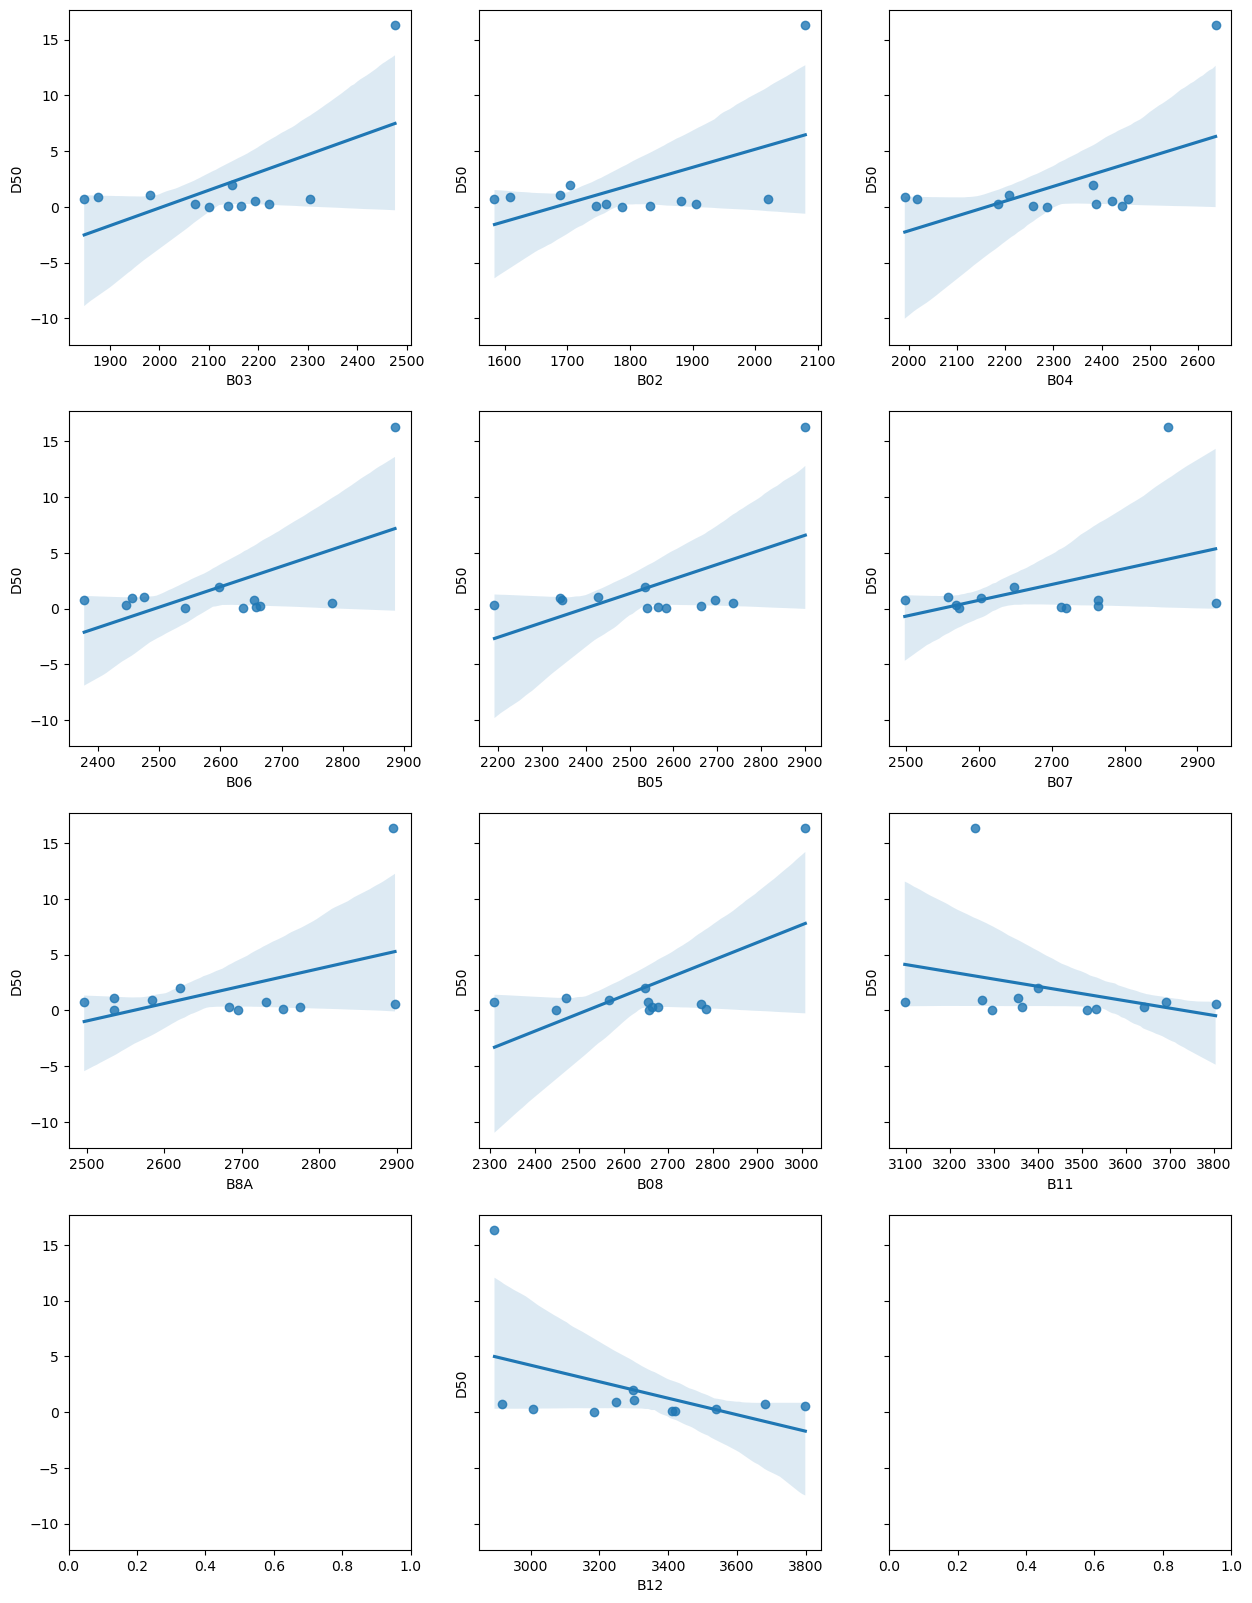

In [53]:
model = smf.ols(formula='D50 ~ B02', data=df).fit()
display(model.summary())
model = smf.ols(formula='D50 ~ B03', data=df).fit()
display(model.summary())
model = smf.ols(formula='D50 ~ B04', data=df).fit()
display(model.summary())
model = smf.ols(formula='D50 ~ B05', data=df).fit()
display(model.summary())
model = smf.ols(formula='D50 ~ B06', data=df).fit()
display(model.summary())
model = smf.ols(formula='D50 ~ B07', data=df).fit()
display(model.summary())
model = smf.ols(formula='D50 ~ B08', data=df).fit()
display(model.summary())
model = smf.ols(formula='D50 ~ B8A', data=df).fit()
display(model.summary())
model = smf.ols(formula='D50 ~ B11', data=df).fit()
display(model.summary())
model = smf.ols(formula='D50 ~ B12', data=df).fit()
display(model.summary())

fig, axs = plt.subplots(4, 3, sharey=True, figsize=(15,20))

print(axs)

sns.regplot(x='B02', y='D50', data=df, ax=axs[0][1])
sns.regplot(x='B03', y='D50', data=df, ax=axs[0][0])
sns.regplot(x='B04', y='D50', data=df, ax=axs[0][2])
sns.regplot(x='B05', y='D50', data=df, ax=axs[1][1])
sns.regplot(x='B06', y='D50', data=df, ax=axs[1][0])
sns.regplot(x='B07', y='D50', data=df, ax=axs[1][2])
sns.regplot(x='B08', y='D50', data=df, ax=axs[2][1])
sns.regplot(x='B8A', y='D50', data=df, ax=axs[2][0])
sns.regplot(x='B11', y='D50', data=df, ax=axs[2][2])
sns.regplot(x='B12', y='D50', data=df, ax=axs[3][1])

plt.show()

# Random Forest Regression

Clearly no linearity can be found at these spatial scale (0.6m). This is likely telling us that the texture features are all but lost at this resolution for detecting particle sizes of this size (<2mm)

In [55]:
y = df['D50']
X = df[BANDS]
display(X)
display(y)
type(y)

,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12
0,2286.0,2100.0,1788.0,2539.0,2543.0,2573.0,2448.0,2535.0,3296.0,3183.0
1,2258.0,2138.0,1832.0,2583.0,2637.0,2720.0,2658.0,2696.0,3511.0,3418.0
2,2442.0,2164.0,1746.0,2566.0,2659.0,2713.0,2784.0,2754.0,3533.0,3412.0
3,2388.0,2222.0,1906.0,2664.0,2664.0,2763.0,2678.0,2775.0,3641.0,3538.0
4,2186.0,2072.0,1762.0,2192.0,2446.0,2569.0,2664.0,2684.0,3365.0,3008.0
5,2018.0,1848.0,1584.0,2346.0,2378.0,2498.0,2310.0,2497.0,3098.0,2918.0
6,2454.0,2304.0,2020.0,2695.0,2655.0,2763.0,2654.0,2731.0,3691.0,3682.0
7,2422.0,2194.0,1882.0,2737.0,2782.0,2925.0,2774.0,2898.0,3804.0,3798.0
8,1992.0,1876.0,1608.0,2342.0,2456.0,2603.0,2568.0,2585.0,3273.0,3249.0
9,2208.0,1980.0,1688.0,2428.0,2475.0,2558.0,2470.0,2535.0,3356.0,3301.0


0      0.026002
1      0.061421
2      0.123040
3      0.279931
4      0.288299
5      0.746540
6      0.756305
7      0.544344
8      0.925641
9      1.077730
10     1.984197
11    16.315145
Name: D50, dtype: float64

pandas.core.series.Series

In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [57]:
X_test

,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12
10,2382.0,2146.0,1704.0,2535.0,2598.0,2648.0,2648.0,2621.0,3401.0,3296.0
9,2208.0,1980.0,1688.0,2428.0,2475.0,2558.0,2470.0,2535.0,3356.0,3301.0
0,2286.0,2100.0,1788.0,2539.0,2543.0,2573.0,2448.0,2535.0,3296.0,3183.0


In [58]:
# Train the model
rf = RandomForestRegressor(n_estimators = 10, max_depth = 10, random_state = 42)
rf.fit(X_train, y_train.values.ravel())

RandomForestRegressor(max_depth=10, n_estimators=10, random_state=42)

In [59]:
import warnings
warnings.filterwarnings('ignore')

# Make prediction
predictions = rf.predict(X_test)

result = X_test.copy()
result['D50'] = y_test
result['D50_pred'] = predictions.tolist()
result.head()

,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12,D50,D50_pred
10,2382.0,2146.0,1704.0,2535.0,2598.0,2648.0,2648.0,2621.0,3401.0,3296.0,1.984197,0.413579
9,2208.0,1980.0,1688.0,2428.0,2475.0,2558.0,2470.0,2535.0,3356.0,3301.0,1.077730,0.407685
0,2286.0,2100.0,1788.0,2539.0,2543.0,2573.0,2448.0,2535.0,3296.0,3183.0,0.026002,0.511609


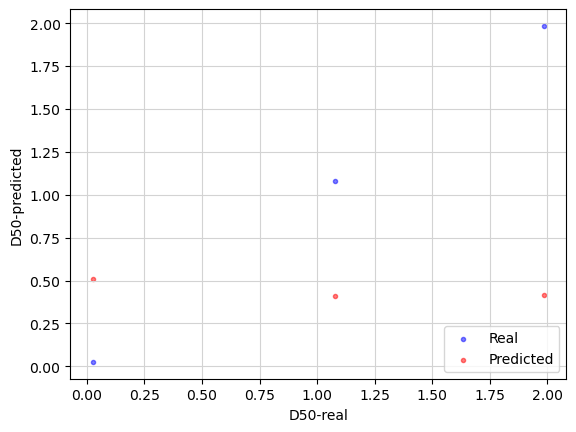

In [64]:
import matplotlib.pyplot as plt

# Define x axis
x_axis = result.D50

# Build scatterplot
plt.scatter(x_axis, y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(x_axis, predictions, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('D50-real')
plt.ylabel('D50-predicted')
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()



## Tuning hyperparameters

In [87]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Find the best parameters for the model
parameters = {
    'max_depth': [70, 80, 90, 100],
    'n_estimators': [100, 500, 1000]
}
gridforest = GridSearchCV(rf, parameters, cv = 3, n_jobs = -1, verbose = 1)
gridforest.fit(X_train, y_train)
gridforest.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


{'max_depth': 70, 'n_estimators': 100}

In [88]:
rf = RandomForestRegressor(n_estimators = 100, max_depth = 70, random_state = 42)
rf.fit(X_train, y_train.values.ravel())


RandomForestRegressor(max_depth=70, random_state=42)

In [89]:
X_test

,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12
0,0.1344,0.1254,0.1046,0.1382,0.1379,0.1403,0.1384,0.1391,0.2001,0.1917
1,0.1480,0.1352,0.1158,0.1486,0.1446,0.1468,0.1518,0.1412,0.2030,0.1964
5,0.1656,0.1534,0.1266,0.1727,0.1770,0.1865,0.1894,0.1808,0.2566,0.2401
14,0.2758,0.2502,0.2238,0.2754,0.2590,0.2763,0.3066,0.2705,0.3496,0.3340


In [90]:
# Make prediction
predictions = rf.predict(X_test)

result = X_test.copy()
result['D50'] = y_test
result['D50_pred'] = predictions.tolist()
result.head()

,B04,B03,B02,B05,B06,B07,B08,B8A,B11,B12,D50,D50_pred
0,0.1344,0.1254,0.1046,0.1382,0.1379,0.1403,0.1384,0.1391,0.2001,0.1917,0.661307,0.803168
1,0.1480,0.1352,0.1158,0.1486,0.1446,0.1468,0.1518,0.1412,0.2030,0.1964,0.880677,0.794556
5,0.1656,0.1534,0.1266,0.1727,0.1770,0.1865,0.1894,0.1808,0.2566,0.2401,0.755629,0.640431
14,0.2758,0.2502,0.2238,0.2754,0.2590,0.2763,0.3066,0.2705,0.3496,0.3340,0.601559,0.720348


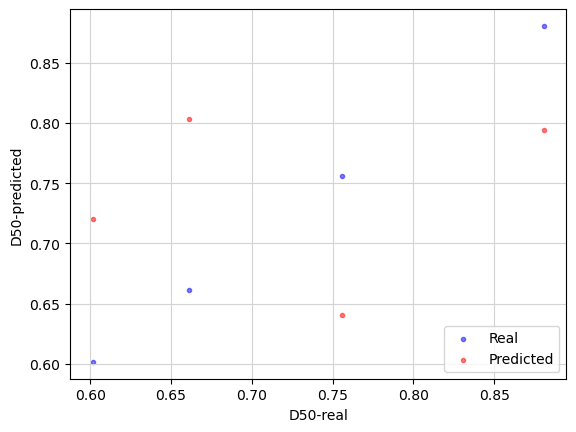

In [91]:
# Define x axis
x_axis = result.D50

# Build scatterplot
plt.scatter(x_axis, y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(x_axis, predictions, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('D50-real')
plt.ylabel('D50-predicted')
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()



## Error Estimation

In [65]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 2))
print('Mean Squared Error:', round(mse, 2))
print('R-squared scores:', round(r2, 2))



Mean Absolute Error: 0.91
Mean Squared Error: 1.05
R-squared scores: -0.64


## Defining and visualizing variables importance

In [66]:
# Get features list
characteristics = X.columns
# Get the variables importances, sort them, and print the result
importances = list(rf.feature_importances_)
characteristics_importances = [(characteristic, round(importance, 2)) for characteristic, importance in zip(characteristics, importances)]
characteristics_importances = sorted(characteristics_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in characteristics_importances];

Variable: B12                  Importance: 0.22
Variable: B02                  Importance: 0.2
Variable: B08                  Importance: 0.2
Variable: B03                  Importance: 0.1
Variable: B11                  Importance: 0.1
Variable: B06                  Importance: 0.08
Variable: B07                  Importance: 0.07
Variable: B04                  Importance: 0.01
Variable: B05                  Importance: 0.01
Variable: B8A                  Importance: 0.01


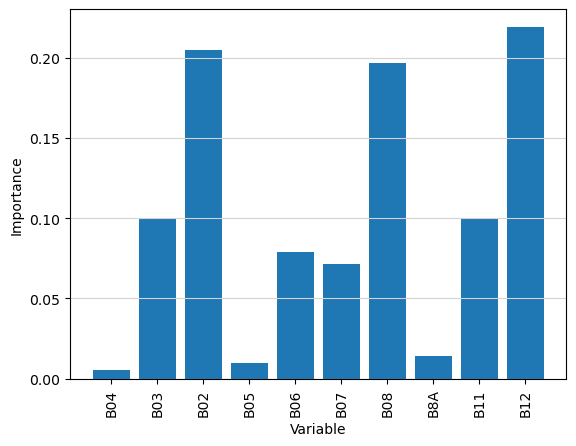

In [67]:
# Visualize the variables importances
plt.bar(characteristics, importances, orientation = 'vertical')
plt.xticks(rotation = 'vertical')
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.grid(axis = 'y', color = '#D3D3D3', linestyle = 'solid')
plt.show()